In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import trimesh
import argparse
import os
import time
import numpy as np
import torch
import torch.optim as optim
import lib.utils as utils
from lib.utils import standard_normal_logprob
from lib.utils import count_nfe, count_total_time
from lib.utils import build_model_tabular
import pandas as pd
import random
from lib.visualize_flow import visualize_transform
import lib.layers.odefunc as odefunc
from matplotlib import pyplot as plt
%matplotlib inline 
import glob
import pyntcloud

In [2]:
SOLVERS = ["dopri5"]
parser = argparse.ArgumentParser('SoftFlow')
parser.add_argument(
    '--data', choices=['2spirals_1d','2spirals_2d', 'swissroll_1d','swissroll_2d', 'circles_1d', 'circles_2d', '2sines_1d', 'target_1d'],
    type=str, default='3d_microgel'
)
parser.add_argument("--layer_type", type=str, default="concatsquash", choices=["concatsquash"])
parser.add_argument('--dims', type=str, default='64-64-64')
parser.add_argument("--num_blocks", type=int, default=1, help='Number of stacked CNFs.')
parser.add_argument('--time_length', type=float, default=0.5)
parser.add_argument('--train_T', type=eval, default=True)
parser.add_argument("--divergence_fn", type=str, default="brute_force", choices=["brute_force", "approximate"])
parser.add_argument("--nonlinearity", type=str, default="tanh", choices=odefunc.NONLINEARITIES)

parser.add_argument('--solver', type=str, default='dopri5', choices=SOLVERS)
parser.add_argument('--atol', type=float, default=1e-5)
parser.add_argument('--rtol', type=float, default=1e-5)

parser.add_argument('--residual', type=eval, default=False, choices=[True, False])
parser.add_argument('--rademacher', type=eval, default=False, choices=[True, False])
parser.add_argument('--spectral_norm', type=eval, default=False, choices=[True, False])
parser.add_argument('--niters', type=int, default=36000)
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--test_batch_size', type=int, default=1000)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--weight_decay', type=float, default=1e-5)

# for the proposed method
parser.add_argument('--std_min', type=float, default=0.0)
parser.add_argument('--std_max', type=float, default=0.1)
parser.add_argument('--std_weight', type=float, default=2)

parser.add_argument('--viz_freq', type=int, default=100)
parser.add_argument('--val_freq', type=int, default=400)
parser.add_argument('--log_freq', type=int, default=10)
parser.add_argument('--gpu', type=int, default=0)
# args = parser.parse_args()
args, unknown = parser.parse_known_args()


In [3]:
# logger
args.data = "microgel_multiclass"
save_path = './results/' + args.data + '/SoftFlow'
utils.makedirs(save_path)

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [4]:
def get_transforms(model):

    def sample_fn(z, logpz=None):
        zeors_std = torch.zeros(z.shape[0], 1).to(z)
        
        if logpz is not None:
            return model(z, zeors_std, logpz, reverse=True)
        else:
            return model(z, zeors_std, reverse=True)

    def density_fn(x, logpx=None):
        zeors_std = torch.zeros(x.shape[0], 1).to(x)
        
        if logpx is not None:
            return model(x, zeors_std, logpx, reverse=False)
        else:
            return model(x, zeors_std, reverse=False)

    return sample_fn, density_fn

DATA_add = "/home/staff/azad/deeplearning/pointcloud/PAINT_DiffTemp/Core-shell/"
Type     = ['Microgel_plotter_v1_density', 'Microgel_plotter_v2_solvatochromism']

temperature_list = os.listdir(DATA_add)
temperature_list.sort()


def get_data(idt = None):
    if idt!=None:
        idt = str(idt)+'C/'
        DATA_list = glob.glob(DATA_add+idt+Type[0]+"/*.3d")
    else:
        DATA_list = glob.glob(DATA_add+'35C/'+Type[0]+"/*.3d")
    temperature = int(temperature_list[0][-3:-1])
    indx = random.randint(0,len(DATA_list)-1)
    DATA = pd.read_csv(DATA_list[indx], delimiter = "\t", header=None)
    DATA = DATA.to_numpy()[:,:3]
    DATA -= np.mean(DATA, axis=0) 
    DATA = (DATA-np.min(DATA, axis=0))/(np.max(DATA, axis=0)-np.min(DATA, axis=0)) 
    newrow = [temperature, temperature, temperature]
    DATA = np.vstack([newrow, DATA])

    return DATA


def compute_loss(args, model, batch_size=None):
    if batch_size is None: batch_size = args.batch_size
    x = get_data()


    x = torch.from_numpy(x).type(torch.float32).to(device)
    zero = torch.zeros(x.shape[0], 1).to(x)

    # transform to z
    std = (args.std_max - args.std_min) * torch.rand_like(x[:,0]).view(-1,1) + args.std_min
    eps = torch.randn_like(x) * std
    std_in = std / args.std_max * args.std_weight
#     print(x.shape, std_in.shape, zero.shape)
    z, delta_logp = model(x+eps, std_in, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    loss = -torch.mean(logpx)
    return loss

In [5]:
model = build_model_tabular(args, 3).to(device)
args.data = "microgel_multiclass"
save_path = './results/' + args.data + '/SoftFlow'
softflow_path = os.path.join(save_path, 'checkpt.pth')
ckpt_softflow = torch.load(softflow_path)
model.load_state_dict(ckpt_softflow['state_dict'])
model.eval()



SequentialFlow(
  (chain): ModuleList(
    (0): CNF(
      (odefunc): RegularizedODEfunc(
        (odefunc): ODEfunc(
          (diffeq): ODEnet(
            (layers): ModuleList(
              (0): ConcatSquashLinear(
                (_layer): Linear(in_features=3, out_features=64, bias=True)
                (_hyper_bias): Linear(in_features=2, out_features=64, bias=False)
                (_hyper_gate): Linear(in_features=2, out_features=64, bias=True)
              )
              (1): ConcatSquashLinear(
                (_layer): Linear(in_features=64, out_features=64, bias=True)
                (_hyper_bias): Linear(in_features=2, out_features=64, bias=False)
                (_hyper_gate): Linear(in_features=2, out_features=64, bias=True)
              )
              (2): ConcatSquashLinear(
                (_layer): Linear(in_features=64, out_features=64, bias=True)
                (_hyper_bias): Linear(in_features=2, out_features=64, bias=False)
                (_hyper_gate): Li

In [6]:
LOW = -4
HIGH = 4
def visualize3d(samples, prior_sample, prior_logdensity, n_samples, transform, inverse_transform, memory=100, title1="$x ~ p(x)$", title2="$q(x)$", title3="$x ~ q(x)$", device="cpu", npts = 100):
    ## first one
    fig = plt.figure(figsize=(25,5))
    ax1 = fig.add_subplot(1, 3, 1, projection="3d")
    ax1.scatter(samples[:, 0], samples[:, 1], samples[:, 2], s=1, c='b', marker="s", facecolor="red", lw=0, alpha=1)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(title1)
    
    ## second one
    side = np.linspace(LOW, HIGH, npts)
    xx, yy, zz = np.meshgrid(side, side, side)
    memory=100
    x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)])
    x = torch.from_numpy(x).type(torch.float32).to(device)
    zeros = torch.zeros(x.shape[0], 1).to(x)

    z, delta_logp = [], []
    inds = torch.arange(0, x.shape[0]).to(torch.int64)
    for ii in torch.split(inds, int(memory**2)):
        z_, delta_logp_ = inverse_transform(x[ii], zeros[ii])
        z.append(z_)
        delta_logp.append(delta_logp_)
    z = torch.cat(z, 0)
    delta_logp = torch.cat(delta_logp, 0)

    logpz = prior_logdensity(z).view(z.shape[0], -1).sum(1, keepdim=True)  # logp(z)
    logpx = logpz - delta_logp

    px = np.exp(logpx.detach().cpu().numpy()).reshape(npts, npts,npts)
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(px[:,:,1])
    ax.set_title(title2)
    
    ## Third one
    z = prior_sample(n_samples, 3).type(torch.float32).to(device)
    zk = []
    inds = torch.arange(0, z.shape[0]).to(torch.int64)
    for ii in torch.split(inds, int(memory**2)):
        zk.append(transform(z[ii]))

    zk = torch.cat(zk, 0).detach().cpu().numpy()

    ax1 = fig.add_subplot(1, 3, 3, projection="3d")
    ax1.scatter(zk[:, 0], zk[:, 1], zk[:, 2], s=1, c='r', marker="s", facecolor="red", lw=0, alpha=1)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(title3)

    
def visualize_samples(X, temp = 25):
    fig = plt.figure(figsize=(25,5))
    for idx in range(len(X)):
        ax1 = fig.add_subplot(1, len(X), idx+1, projection="3d")
        samples = X[idx]
        ax1.scatter(samples[:, 0], samples[:, 1], samples[:, 2], s=1, c='b', marker="s", facecolor="red", lw=0, alpha=1)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        ax1.set_title('temperature '+ str(temp)+ 'sample' + str(idx+1))
        
def reconstruct_samples(prior_sample, transform, n_samples = 100, temperature = 23, memory=100, device="cpu"):        
    z = prior_sample(n_samples, 3).type(torch.float32).to(device)
    z[0] = temperature
    zk = []
    inds = torch.arange(0, z.shape[0]).to(torch.int64)
    for ii in torch.split(inds, int(memory**2)):
        zk.append(transform(z[ii]))

    zk = torch.cat(zk, 0).detach().cpu().numpy()
    zk = Refine_PC(zk, confidence = 0.99)
    
    return zk


In [7]:
def calc_mue(M):
    return np.mean(M, axis=0)

def calc_dist(p, mue): 
    return np.linalg.norm(p-mue, 2)

def Refine_PC(points, confidence = 0.99):
    Inlaier_points = []
    mue            = calc_mue(points)
    sorted_dists   = sorted([calc_dist(p, mue) for p in points])
    XY             = [(0, 0)]
    t              = len(sorted_dists)
    for j, d in enumerate(sorted_dists):
        XY.append(( d, 1.*j/t ))
        if 1.*j/t >= confidence:
            break
    sorted_idx     = sorted([(i, calc_dist(p, mue)) for i, p in enumerate(points)], key= lambda d:(d[1], d[0]))
    inlaier        = [d[0] for d in sorted_idx[:j]]
    inlaier_points = [points[j] for j in inlaier]
    points         = np.array(inlaier_points)
    points        -= mue

    return points


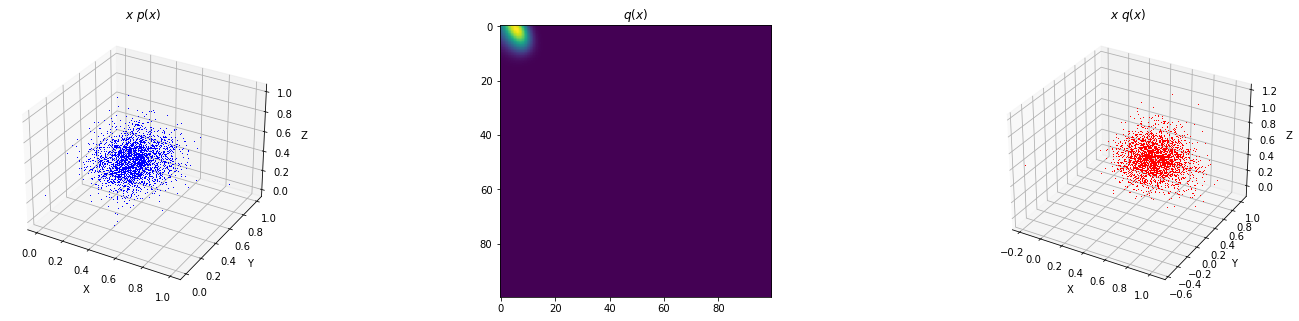

In [8]:
p_samples = get_data()[1:]
sample_fn, density_fn = get_transforms(model)
visualize3d(p_samples, torch.randn, standard_normal_logprob, p_samples.shape[0], sample_fn,density_fn, device=device)
plt.show()


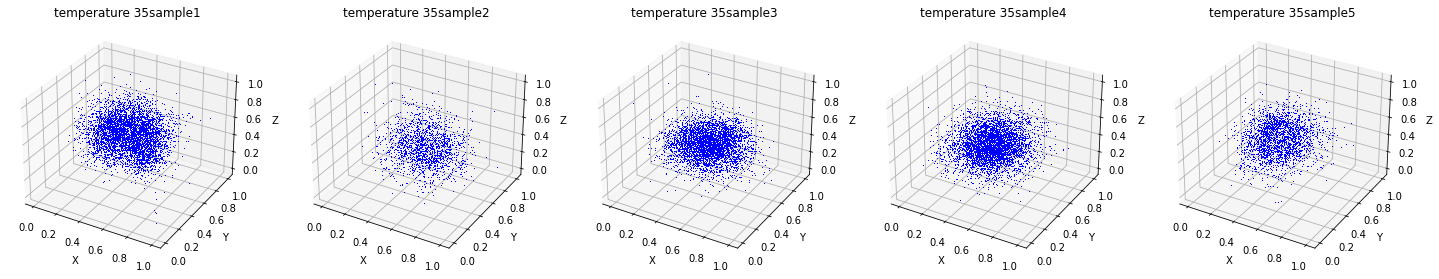

In [10]:
## Visualize sample microgels
N = 5 
#temperatures = {0:21, 1:33, 2:38, 3:53} 
X = []
for idx in range(N):
    p_samples = get_data(idt = 35)[1:]
    X.append(p_samples)
visualize_samples(X, temp = 35)
plt.show()



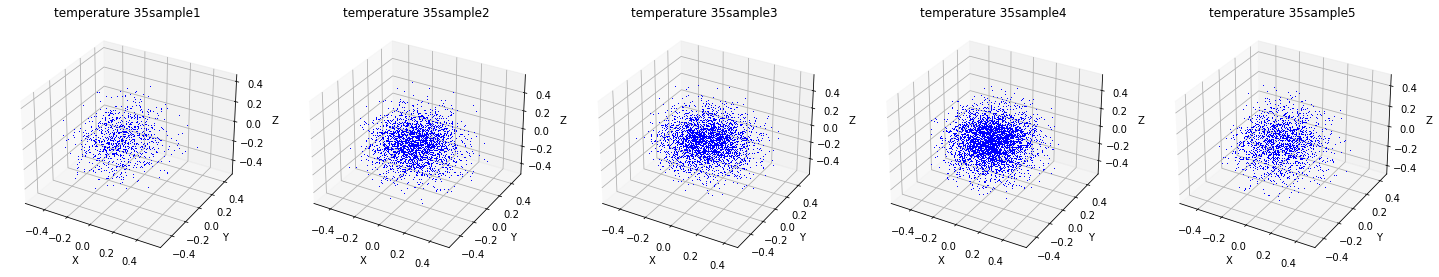

In [11]:
## Visualize sample microgels
N = 5 
#temperatures = {0:21, 1:33, 2:38, 3:53} 
X = []
tmp = 35
for idx in range(N):
    npt = random.randint(500,5000)
    p_samples = reconstruct_samples(torch.randn, sample_fn, n_samples= npt, temperature = tmp, device=device)
    X.append(p_samples[1:])
visualize_samples(X, temp = tmp)
plt.show()

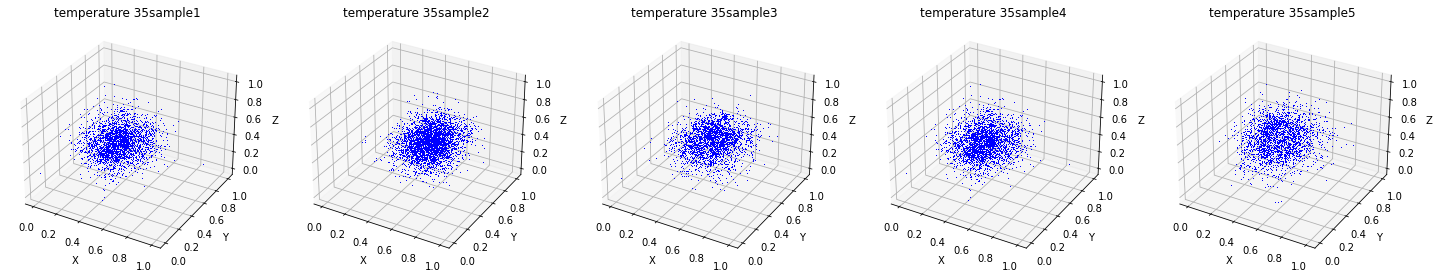

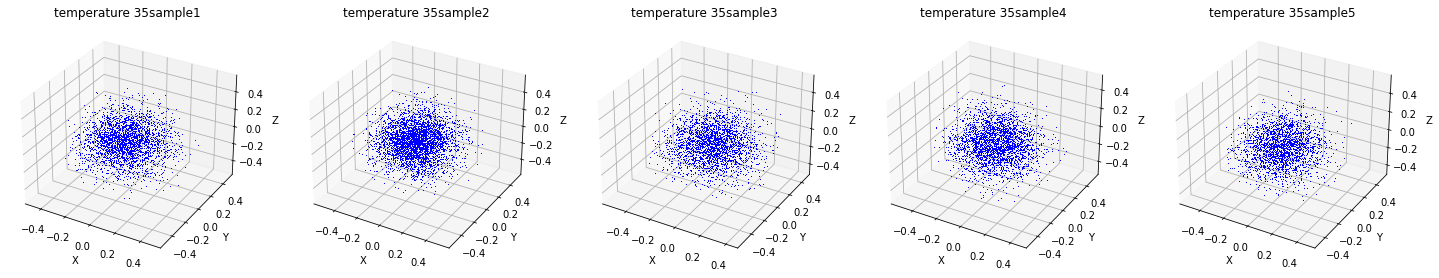

In [12]:
## Visualize sample microgels
N = 5 
temperatures = ['21C', '33C', '35C', '38C', '43C', '53C']
X1 = []
X2 = []
tmp = 35
for idx in range(N):
    p_samples = get_data(idt = tmp)[1:]
    X1.append(p_samples)
    npt = len(p_samples)
    p_samples = reconstruct_samples(torch.randn, sample_fn, n_samples= npt, temperature = tmp, device=device)
    X2.append(p_samples[1:])
visualize_samples(X1, temp = tmp)
plt.show()
visualize_samples(X2, temp = tmp)
plt.show()



In [13]:
N = 5 
#temperatures = {0:21, 1:33, 2:38, 3:53} 
X1 = []
X2 = []
tmp = 35
for idx in range(N):
    p_samples = get_data(idt = tmp)[1:]
    X1.append(p_samples)
    npt = len(p_samples)
    p_samples = reconstruct_samples(torch.randn, sample_fn, n_samples= npt, temperature = tmp, device=device)
    X2.append(p_samples[1:])

   
    
    

In [ ]:
for idx in range(N):
    np.savetxt("./results/g"+str(idx+1)+".ply", X2[idx], delimiter='\t')

